# Sensorless Drive Diagnosis Project

## Purpose of the project

<b>To build a multi-class classification model with numerical attributes</b>


The task is to classify the condition of a synchron motor by using current measurements in the motor. 

After the advances in industrial information technology, condition monitoring methods are becoming increasingly important. The phase currents are used at the evaluation of the process data without additional, cost-intensive sensors and the determination the damage status of a syn-characterize chronomotors and the connected components.


## About the dataset

The original paper is in German language. [Here](https://www.researchgate.net/publication/264273485_Feature_Extraction_and_Reduction_Applied_to_Sensorless_Drive_Diagnosis) is the English version. 

Dataset used in the analysis: Sensorless Drive Diagnosis dataset (SDD): 

https://archive.ics.uci.edu/ml/datasets/Dataset+for+Sensorless+Drive+Diagnosis 

The dataset contains information collected from electric current drive signals of a synchronous electric motor. The current signals are measured with a current probe and an oscilloscope on two phases.

In the raw data there are a lot of measurements (different speeds, load moments and load forces) and different health conditions (motor ok, failure in the bearings, etc. ) 

The raw data is timeseries data. However the dataset provided are only the extracted features from the raw data. 

There are 48 continous predictive features. The target feature contains 11 classes. 


## Setup

### Importing Libraries

In [74]:
import time

import pandas as pd
import numpy as np
np.random.seed(42)

# plot pretty figures
import matplotlib.pyplot as plt
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# sklearn machine learning 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, f1_score, fbeta_score, r2_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# sklearn multi layer perceptron
from sklearn.neural_network import MLPClassifier

import xgboost as xgb

### Functions 

In [126]:
# functions are in a Python script at the same folder. 
%run -i 'functions.py'

In [108]:
# This cell is the same as the above cell. No need to run this. 

def plot_coefficients(clf):
    """
        The function to plot the coefficients of logistic regression model.
  
        Parameters:
            clf: classifier model   
    """
    
    weights_clf = pd.Series(clf.coef_[0], index=scaled_X_train_log.columns.values)
    weights_clf.sort_values(inplace=True)
    plt.figure(figsize=(20, 6))
    plt.xticks(rotation=90)
    #barplot
    features = plt.bar(weights_clf.index, weights_clf.values)
    
    
    
def model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test):
    """
        The function to print the metrics of the model evaluation.
        Printed metrics: Accuracy scores, 
                         confusion matrixes, 
                         and classification reports for train and test sets, 
  
        Parameters: Train, test, and prediction values
                    X_train, X_test, 
                    y_train, y_test, 
                    y_pred_train, y_pred_test   
    """

    print('MODEL EVALUATION METRICS:\n',
          '-----------------------------------------------------')
    print('Train Set Accuracy Score', round(accuracy_score(y_train, y_pred_train), 6))
    print('Test Set Accuracy Score', round(accuracy_score(y_test, y_pred_test),6))
    print('-----------------------------------------------------\n')

    print('Confusion Matrix for train & test set: \n',
          '\nTrain set\n',
          confusion_matrix(y_train, y_pred_train), '\n'
          '\n\nTest set\n',)
    print(confusion_matrix(y_test, y_pred_test), '\n')


    print('-----------------------------------------------------')
    print('\nClassification Report for train & test set\n',
          '\nTrain set\n',
          classification_report(y_train, y_pred_train),
          '\n\nTest set\n',
          classification_report(y_test, y_pred_test))

    print('-----------------------------------------------------\n')

    # print('roc auc score for train and test set:\n ',
    #       round(roc_auc_score(y_train, y_pred_train), 4),
    #       round(roc_auc_score(y_test, y_pred_test), 4))
    
    
def plot_feature_importances(model):
    """
        The function to plot the coefficients of tree based models.
  
        Parameters:
            model: classifier model  
    """
    n_features = X_train.shape[1]
    plt.figure(figsize=(20, 15))
    #barplot
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns.values)
    plt.title('Comparison of Feature Importances')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    

## Load Dataset

In [56]:
df = pd.read_csv("sensorless_drive_diagnosis.txt", delim_whitespace=True, header=None)
header_names = ['feat' + str(i) for i in range(1, df.shape[1])]
header_names.append('class')
df.set_axis(header_names, axis=1, inplace=True)
display(df.head())
display(df.tail())
display(df.describe())

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,...,feat40,feat41,feat42,feat43,feat44,feat45,feat46,feat47,feat48,class
0,-3.014600e-07,8.260300e-06,-0.000012,-0.000002,-1.438600e-06,-0.000021,0.031718,0.031710,0.031721,-0.032963,...,-0.63308,2.9646,8.1198,-1.4961,-1.4961,-1.4961,-1.4996,-1.4996,-1.4996,1
1,2.913200e-06,-5.247700e-06,0.000003,-0.000006,2.778900e-06,-0.000004,0.030804,0.030810,0.030806,-0.033520,...,-0.59314,7.6252,6.1690,-1.4967,-1.4967,-1.4967,-1.5005,-1.5005,-1.5005,1
2,-2.951700e-06,-3.184000e-06,-0.000016,-0.000001,-1.575300e-06,0.000017,0.032877,0.032880,0.032896,-0.029834,...,-0.63252,2.7784,5.3017,-1.4983,-1.4983,-1.4982,-1.4985,-1.4985,-1.4985,1
3,-1.322600e-06,8.820100e-06,-0.000016,-0.000005,-7.282900e-07,0.000004,0.029410,0.029401,0.029417,-0.030156,...,-0.62289,6.5534,6.2606,-1.4963,-1.4963,-1.4963,-1.4975,-1.4975,-1.4976,1
4,-6.836600e-08,5.666300e-07,-0.000026,-0.000006,-7.940600e-07,0.000013,0.030119,0.030119,0.030145,-0.031393,...,-0.63010,4.5155,9.5231,-1.4958,-1.4958,-1.4958,-1.4959,-1.4959,-1.4959,1


,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,...,feat40,feat41,feat42,feat43,feat44,feat45,feat46,feat47,feat48,class
58504,-0.000010,0.000002,-0.000021,0.000021,-0.000006,-0.000098,-0.083417,-0.083419,-0.083398,-0.18234,...,-0.52907,1.4641,7.0032,-1.5024,-1.5025,-1.5023,-1.4933,-1.4933,-1.4933,11
58505,-0.000011,0.000020,0.000031,-0.000018,-0.000106,0.000292,-0.085131,-0.085151,-0.085182,-0.18432,...,-0.51971,3.3275,2.3072,-1.5024,-1.5025,-1.5024,-1.4925,-1.4925,-1.4926,11
58506,-0.000006,0.000019,-0.000102,-0.000003,0.000004,0.000117,-0.081989,-0.082008,-0.081906,-0.18614,...,-0.51103,20.9250,9.0437,-1.5035,-1.5035,-1.5039,-1.4911,-1.4912,-1.4910,11
58507,-0.000004,0.000034,-0.000442,0.000005,0.000007,0.000087,-0.081500,-0.081534,-0.081093,-0.18363,...,-0.52033,1.3890,10.7430,-1.5029,-1.5029,-1.5030,-1.4932,-1.4932,-1.4931,11
58508,-0.000009,0.000052,0.000072,0.000010,0.000004,-0.000032,-0.083034,-0.083086,-0.083159,-0.18589,...,-0.50974,1.6026,4.5773,-1.5039,-1.5040,-1.5036,-1.4945,-1.4946,-1.4943,11


,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,...,feat40,feat41,feat42,feat43,feat44,feat45,feat46,feat47,feat48,class
count,58509.000000,5.850900e+04,5.850900e+04,58509.000000,5.850900e+04,5.850900e+04,58509.000000,58509.000000,58509.000000,58509.000000,...,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000
mean,-0.000003,1.439648e-06,1.412013e-06,-0.000001,1.351239e-06,-2.654483e-07,0.001915,0.001913,0.001912,-0.011897,...,-0.397757,7.293781,8.273772,-1.500887,-1.500912,-1.500805,-1.497771,-1.497794,-1.497686,6.000000
std,0.000072,5.555429e-05,2.353009e-04,0.000063,5.660943e-05,2.261907e-04,0.036468,0.036465,0.036470,0.066482,...,25.018728,12.451781,6.565952,0.003657,0.003668,0.003632,0.003163,0.003163,0.003175,3.162305
min,-0.013721,-5.414400e-03,-1.358000e-02,-0.012787,-8.355900e-03,-9.741300e-03,-0.139890,-0.135940,-0.130860,-0.218640,...,-0.902350,-0.596830,0.320660,-1.525500,-1.526200,-1.523700,-1.521400,-1.523200,-1.521300,1.000000
25%,-0.000007,-1.444400e-05,-7.239600e-05,-0.000005,-1.475300e-05,-7.379100e-05,-0.019927,-0.019951,-0.019925,-0.032144,...,-0.715470,1.450300,4.436300,-1.503300,-1.503400,-1.503200,-1.499600,-1.499600,-1.499500,3.000000
50%,-0.000003,8.804600e-07,5.137700e-07,-0.000001,7.540200e-07,-1.659300e-07,0.013226,0.013230,0.013247,-0.015566,...,-0.661710,3.301300,6.479100,-1.500300,-1.500300,-1.500300,-1.498100,-1.498100,-1.498000,6.000000
75%,0.000002,1.877700e-05,7.520000e-05,0.000004,1.906200e-05,7.138600e-05,0.024770,0.024776,0.024777,0.020614,...,-0.573980,8.288500,9.857500,-1.498200,-1.498200,-1.498200,-1.496200,-1.496300,-1.496200,9.000000
max,0.005784,4.525300e-03,5.237700e-03,0.001453,8.245100e-04,2.753600e-03,0.069125,0.069130,0.069131,0.352580,...,3670.800000,889.930000,153.150000,-1.457600,-1.456100,-1.455500,-1.337200,-1.337200,-1.337100,11.000000


## Basic EDA

### Checking Missing Values

There are not any misssing values. 

In [57]:
df.isna().sum().sum()

0

### Checking the basic info

48non-null float(features), 1 non-null integer(target)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58509 entries, 0 to 58508
Data columns (total 49 columns):
feat1     58509 non-null float64
feat2     58509 non-null float64
feat3     58509 non-null float64
feat4     58509 non-null float64
feat5     58509 non-null float64
feat6     58509 non-null float64
feat7     58509 non-null float64
feat8     58509 non-null float64
feat9     58509 non-null float64
feat10    58509 non-null float64
feat11    58509 non-null float64
feat12    58509 non-null float64
feat13    58509 non-null float64
feat14    58509 non-null float64
feat15    58509 non-null float64
feat16    58509 non-null float64
feat17    58509 non-null float64
feat18    58509 non-null float64
feat19    58509 non-null float64
feat20    58509 non-null float64
feat21    58509 non-null float64
feat22    58509 non-null float64
feat23    58509 non-null float64
feat24    58509 non-null float64
feat25    58509 non-null float64
feat26    58509 non-null float64
feat27    58509 non-null float64


### Checking Class Imbalance

There is not a class imbalance issue. All the classes have the same number of samples. 

In [59]:
df.groupby('class').size()

class
1     5319
2     5319
3     5319
4     5319
5     5319
6     5319
7     5319
8     5319
9     5319
10    5319
11    5319
dtype: int64

### Seperating Target and Features

In [60]:
X = df.drop(['class'], axis=1)
y = df['class']

### Making a random sample 


In [61]:
df_sample = df.sample(500)

## Data Visualizations

### Histograms
Results of the histograms: There are a lot of features that have exact same distribution. There can be a high correlation between features. For example <b>feat24</b>, <b>feat25</b>, <b>feat26</b>, <b>feat27</b> are the same. 

A heatmap can help us see the amount of correlation. 

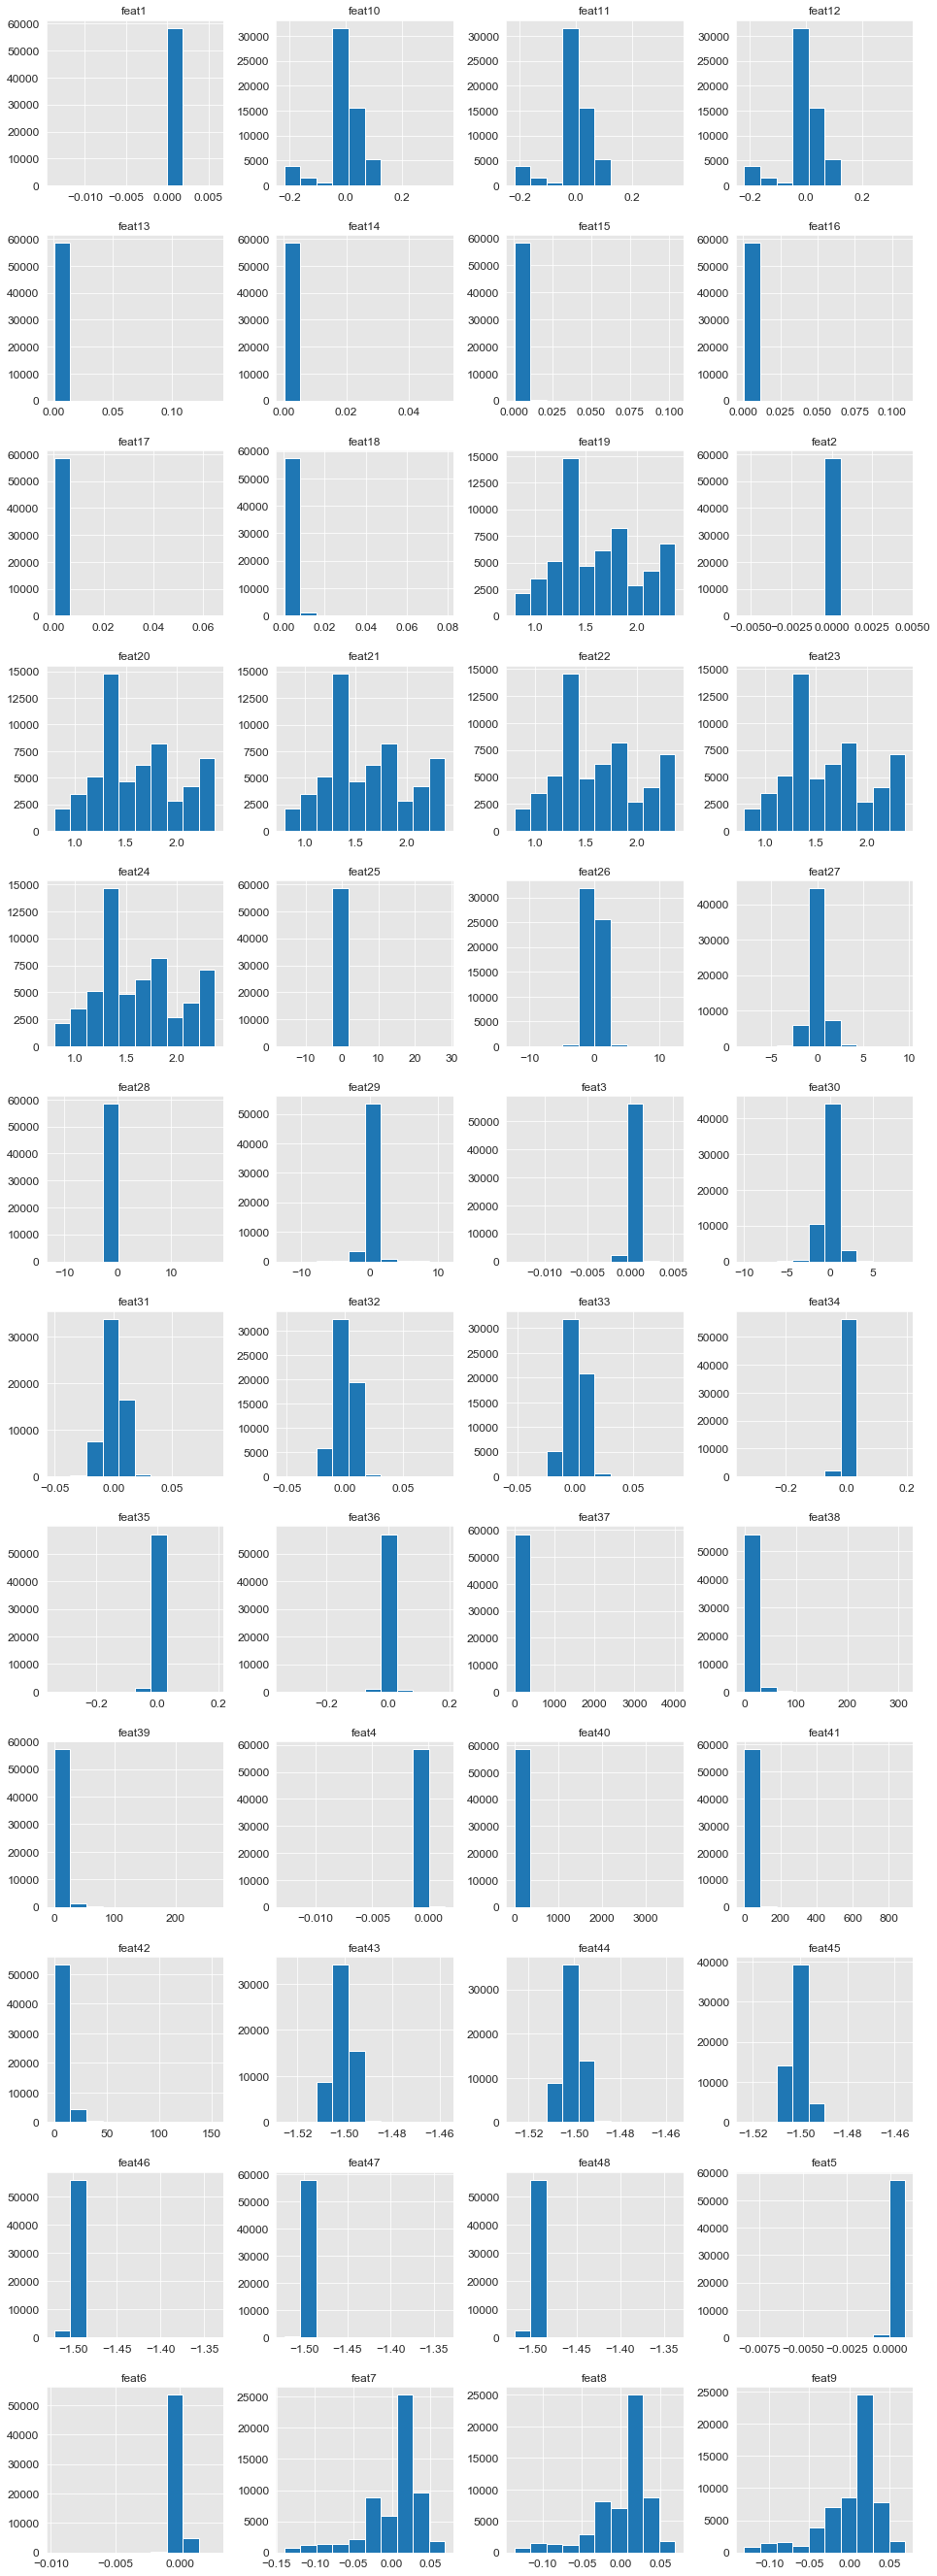

In [62]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 48
plt.rcParams["figure.figsize"] = fig_size
# plt.figure(figsize=(16,48))
X.hist(layout=(12,4))
plt.show()


### Heatmaps

Heatmap with annotations show the correlated columns and the amount of correlation. 

#### Heatmap 1
At the below map, <b>18 columns</b> are 100% correlated to each other. Dropping them in the beginning of the analysis. 


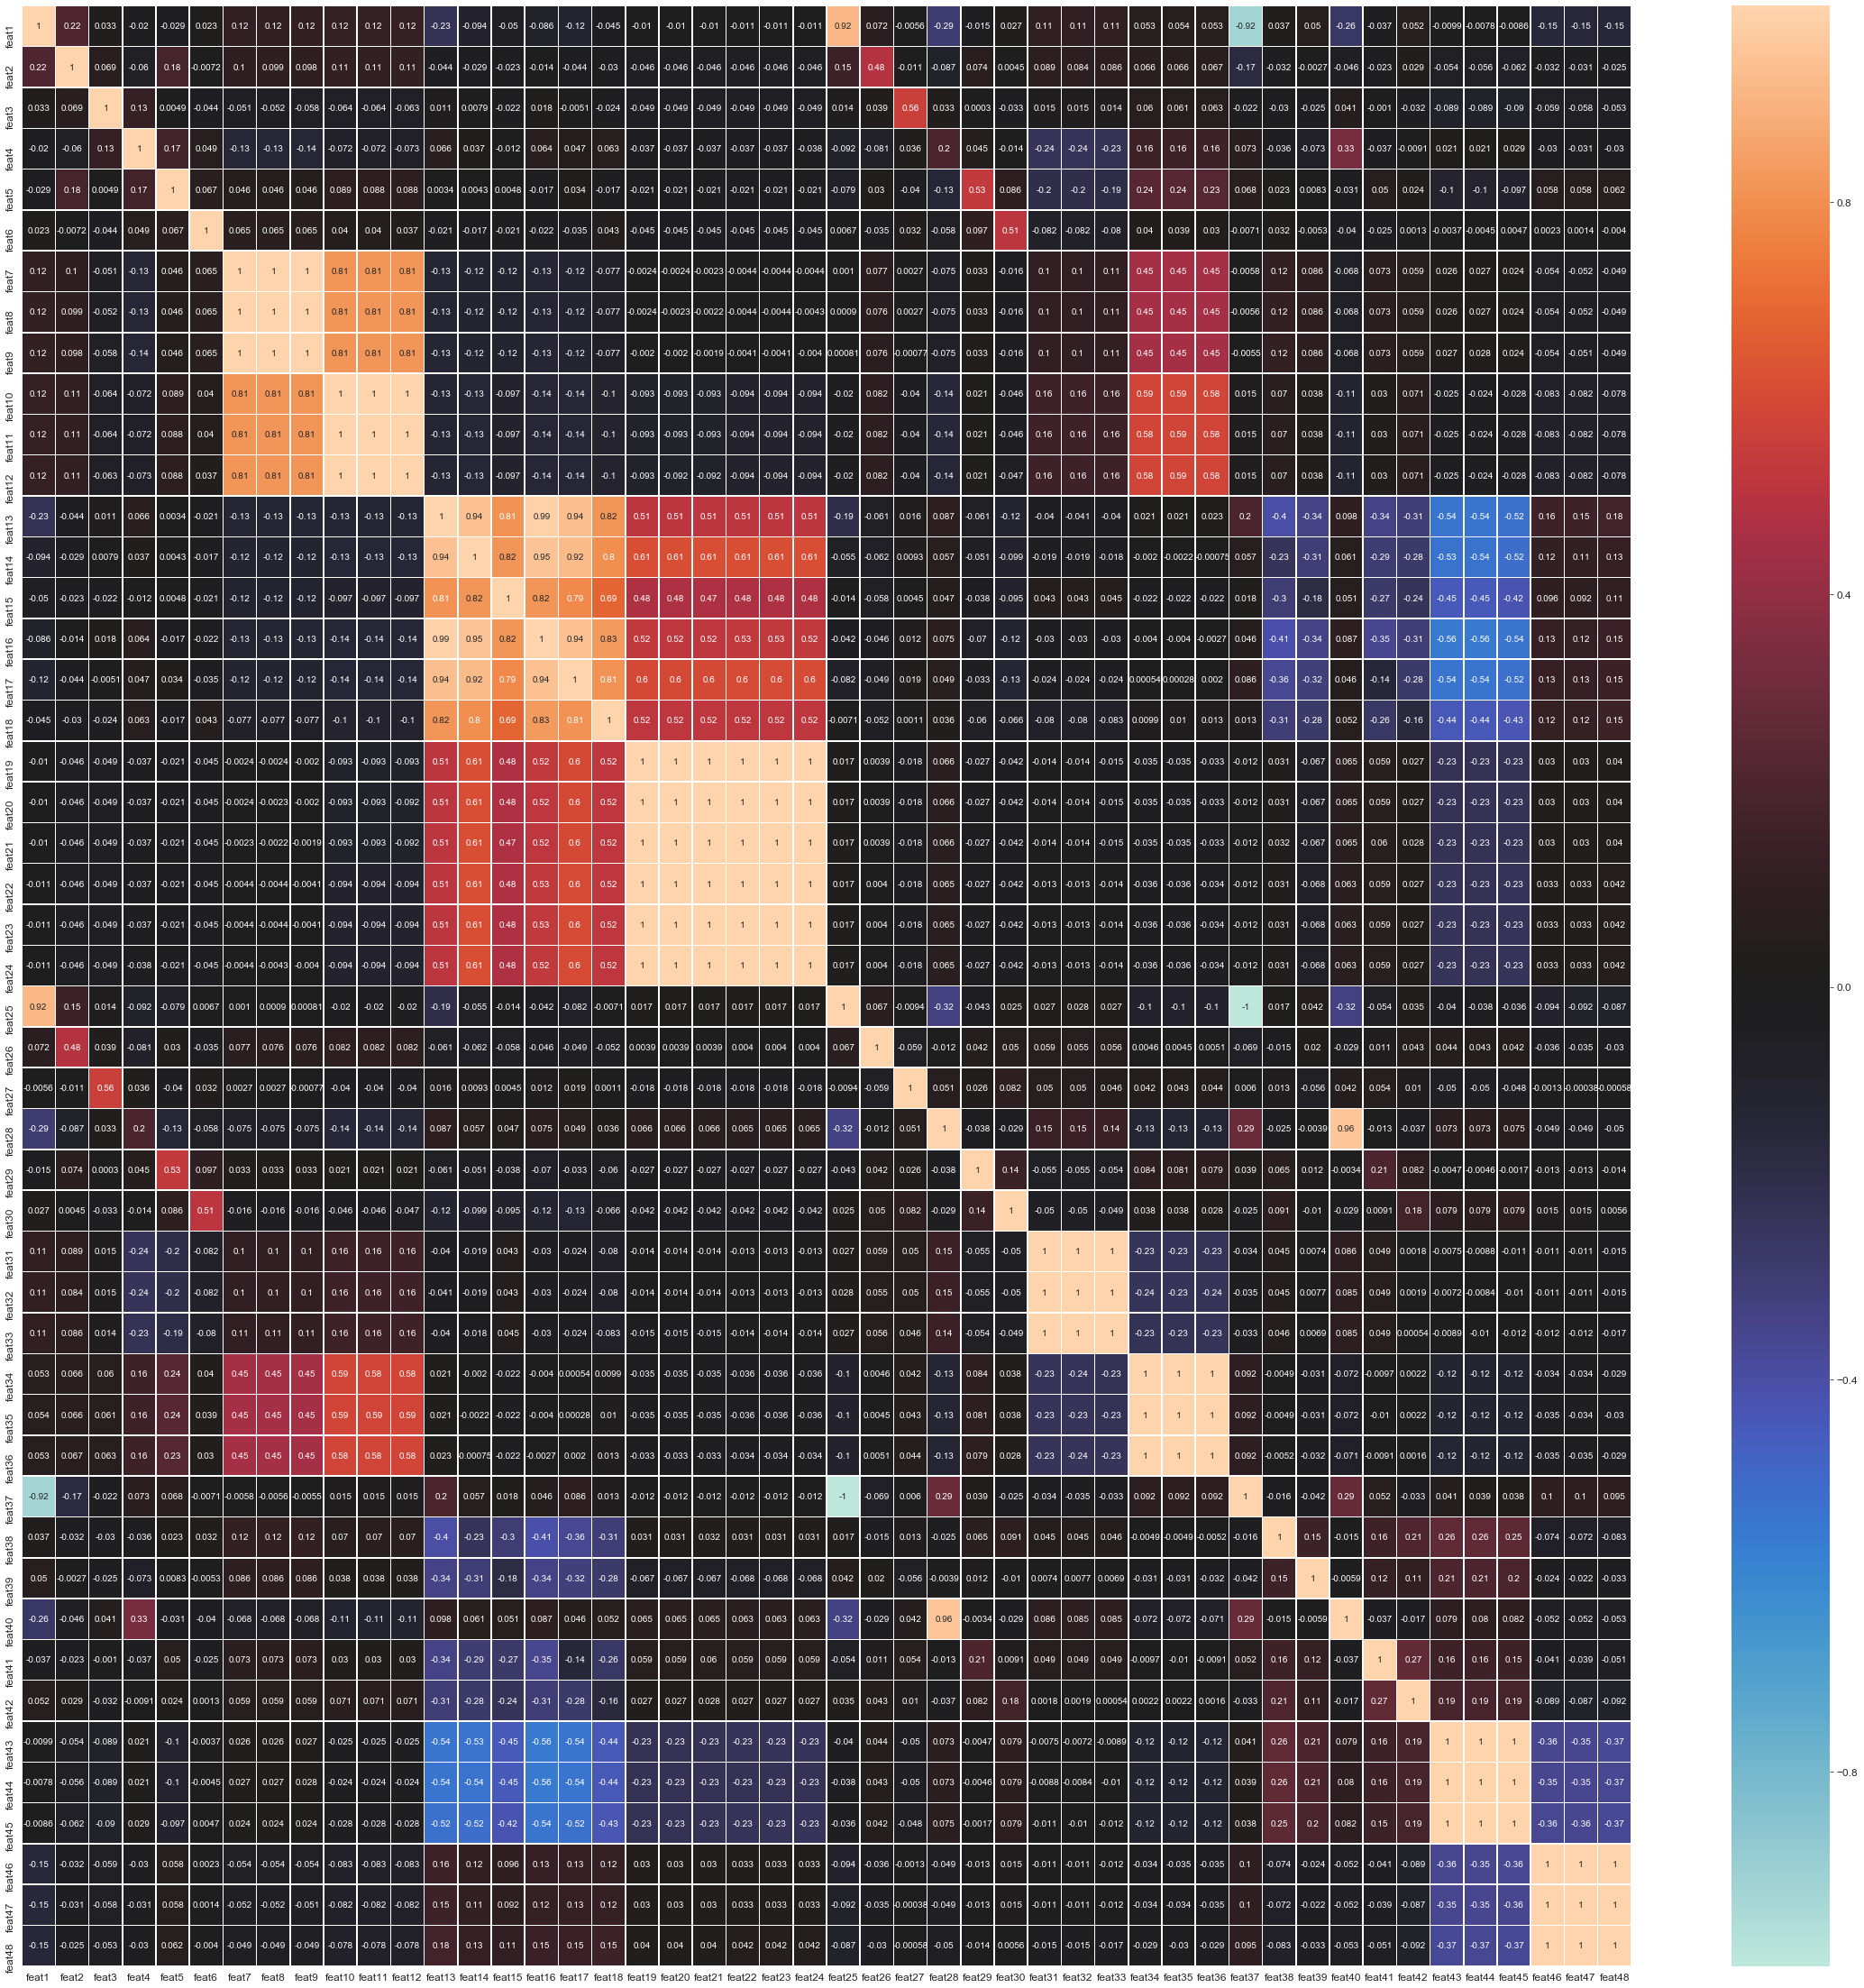

In [63]:
df_heatmap = df_sample.drop(['class'], axis=1)
plt.figure(figsize=(40, 40))
ax = sns.heatmap(df_heatmap.corr(), center=0, linewidths=.5, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

#### Dropping Correlated Columns

18 columns are dropped, 30 columns are kept

In [64]:
# 100% correlated columns are dropped
columns_to_drop = ['feat8', 'feat9', 'feat11', 'feat12', 'feat16',
                   'feat20','feat21','feat22','feat23','feat24', 
                   'feat32','feat33','feat35', 'feat36',
                   'feat44','feat45','feat47','feat48']
df = df.drop(columns_to_drop, axis=1)

#### Heatmap 2

According to the heatmap below, there are not 100% correlated columns but <b>feat13</b>, <b>feat15</b>, <b>feat17</b> are also highly correlated to <b>feat14</b>. They can affect the logistic regression model. 

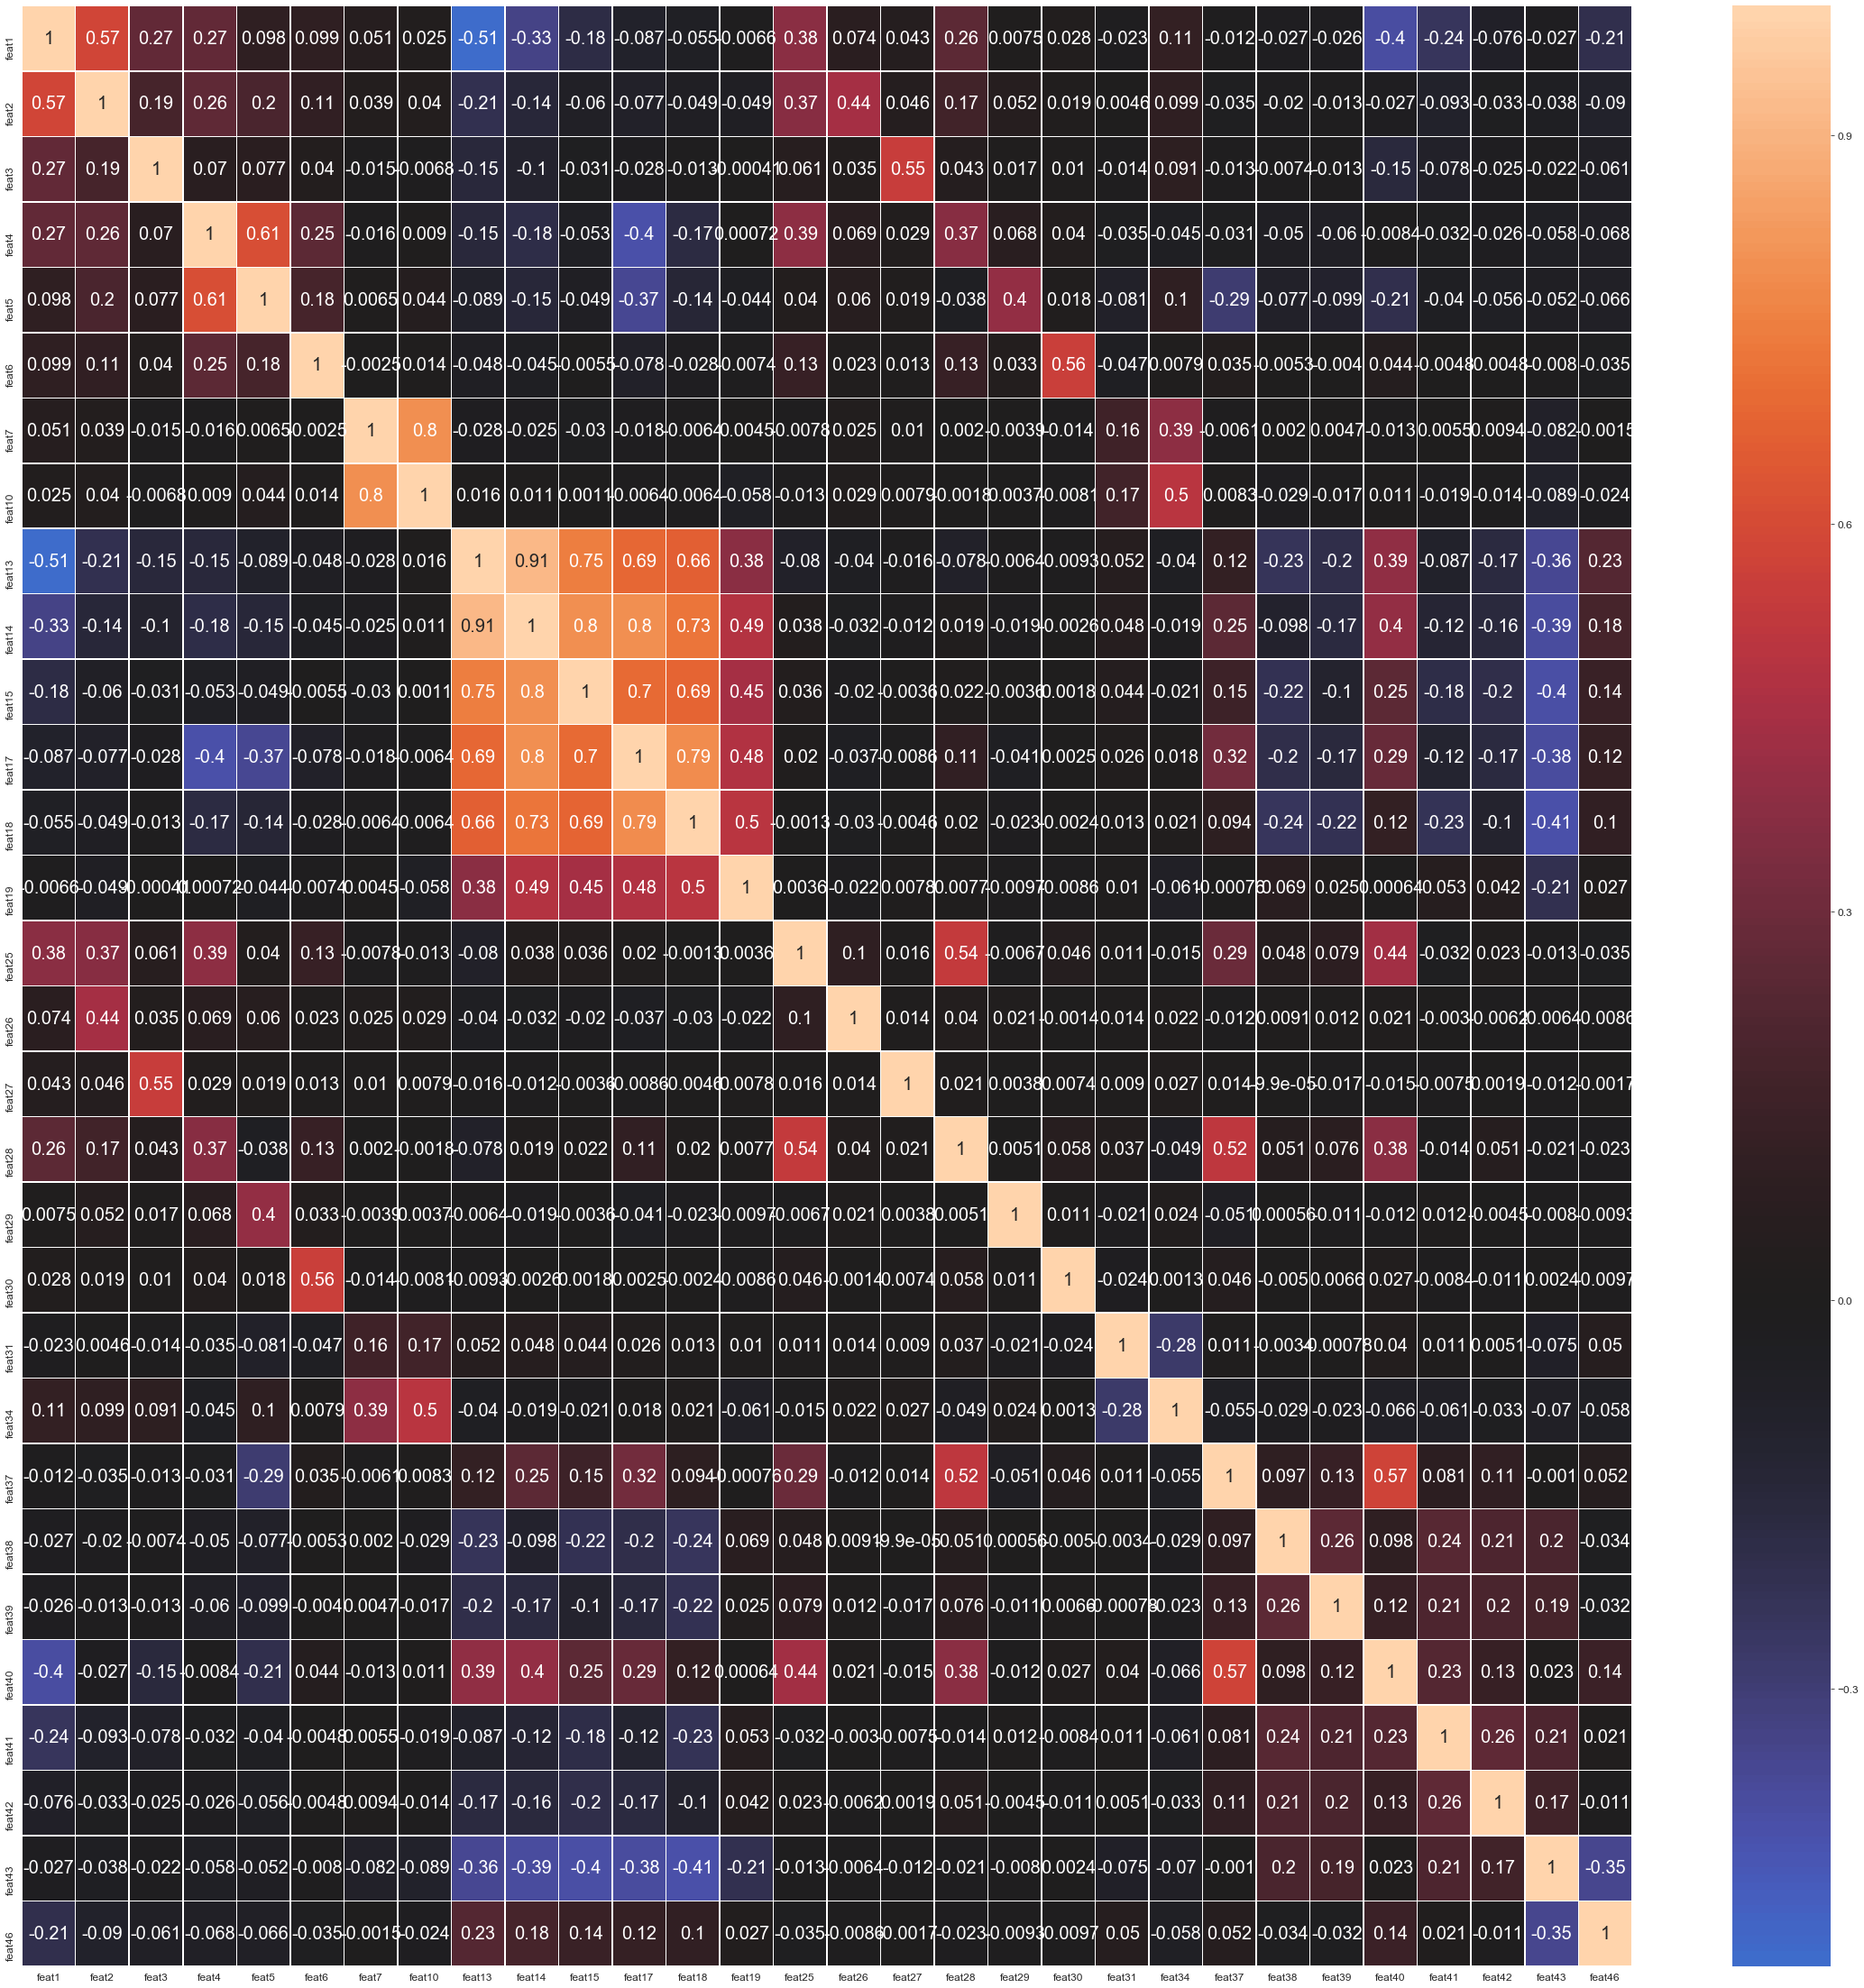

In [65]:
df_heatmap = df.drop(['class'], axis=1) # dropping target columns and making correlation heatmap of features. 
plt.figure(figsize=(40, 40)) 
ax = sns.heatmap(df_heatmap.corr(), center=0, linewidths=.5, annot=True, annot_kws={"size": 20})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5) # this line is to fix a bug at the heatmap
plt.show()

#### Boxplots

##### Seperating target and features after dropping columns

In [66]:
X = df.drop(['class'], axis=1)
y = df['class']

##### Scaling Features To Get Better Boxplots (MinMax Scaler)

In [67]:
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
# scaled_X = pd.DataFrame(scaled_x_train, columns=X_train.columns)

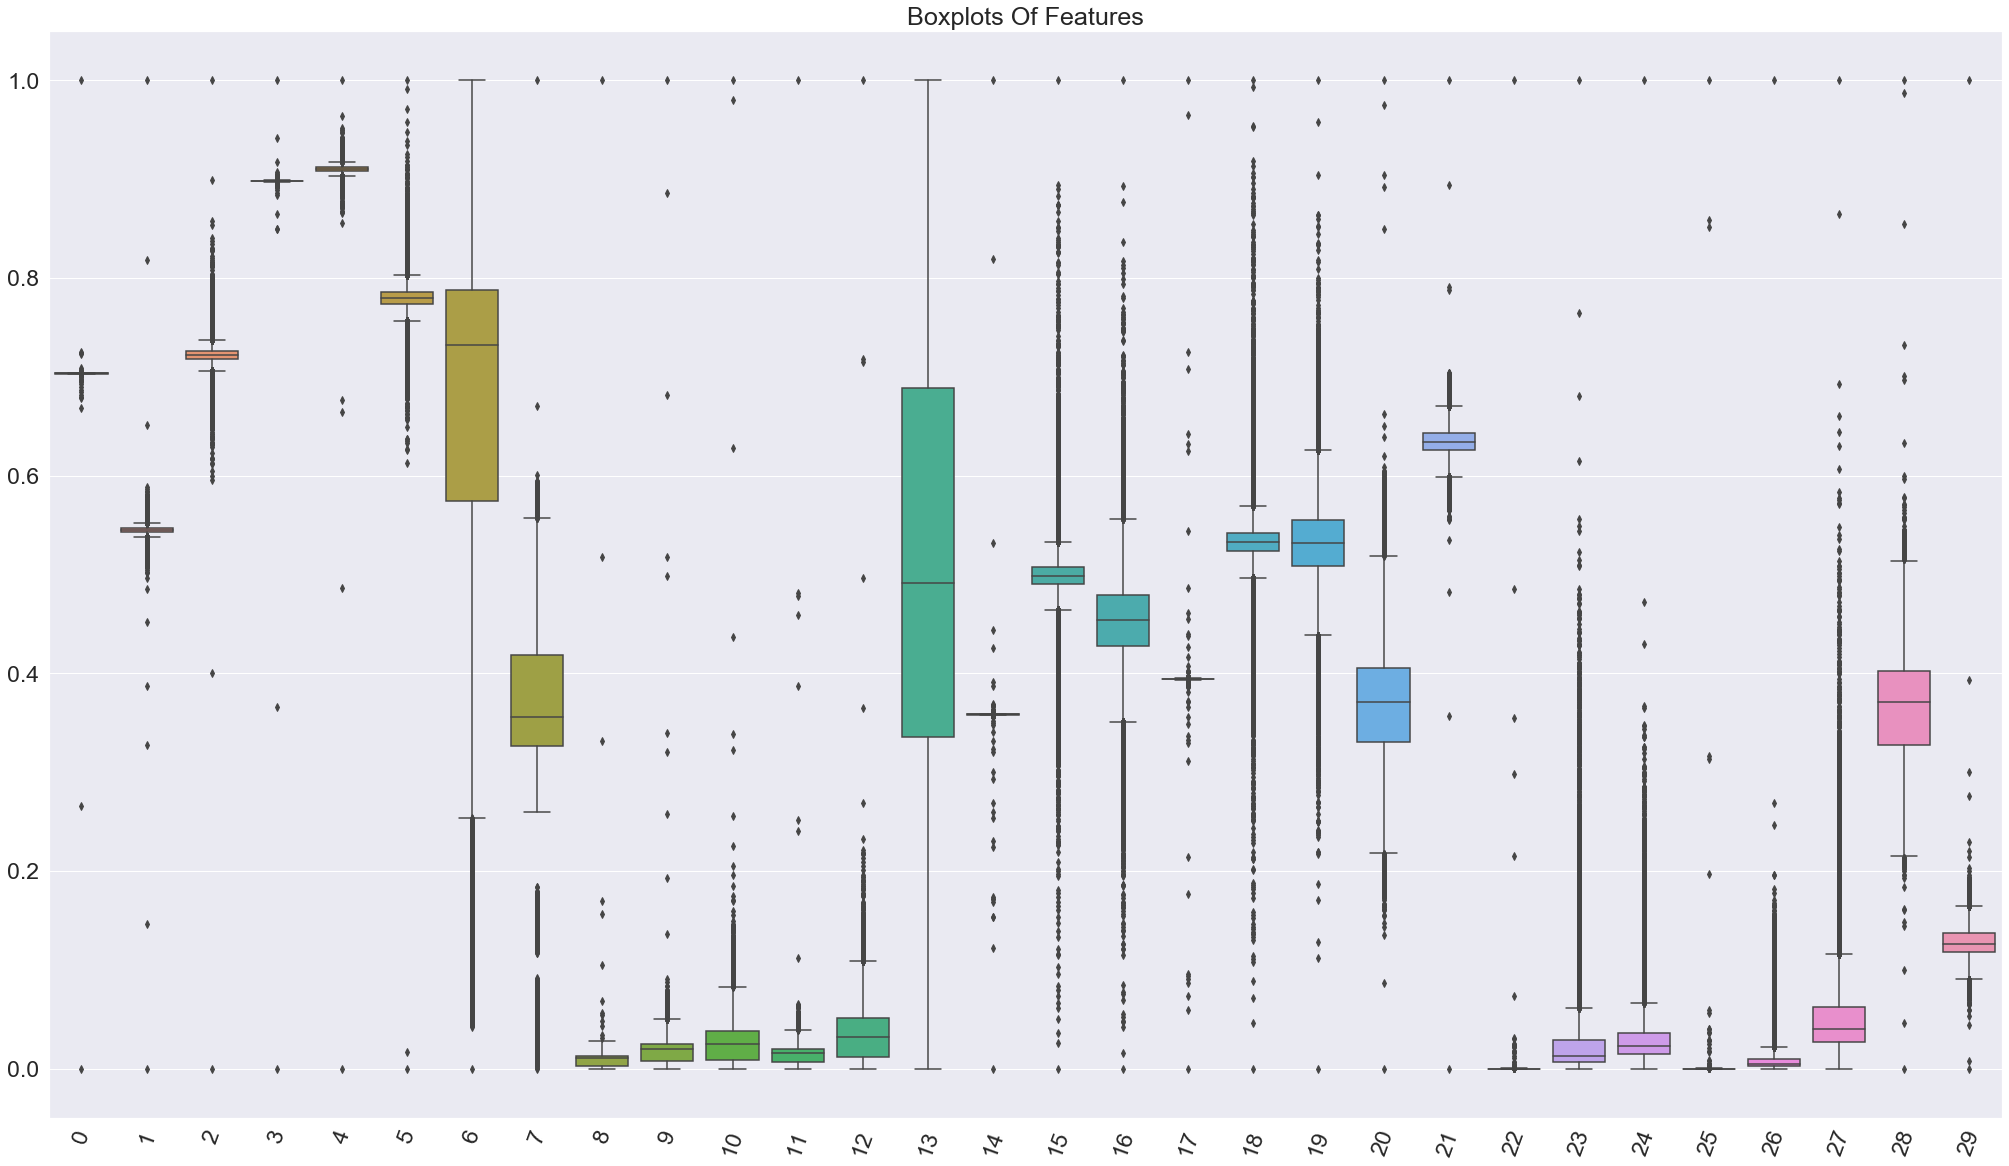

In [68]:
sns.set(rc={'figure.figsize': (35, 20)},font_scale=2.1)  # Set font scale   
g = sns.boxplot(data=scaled_X)
for item in g.get_xticklabels():  # Rotate x labels to 70 degrees angle
    item.set_rotation(70)
plt.title('Boxplots Of Features');

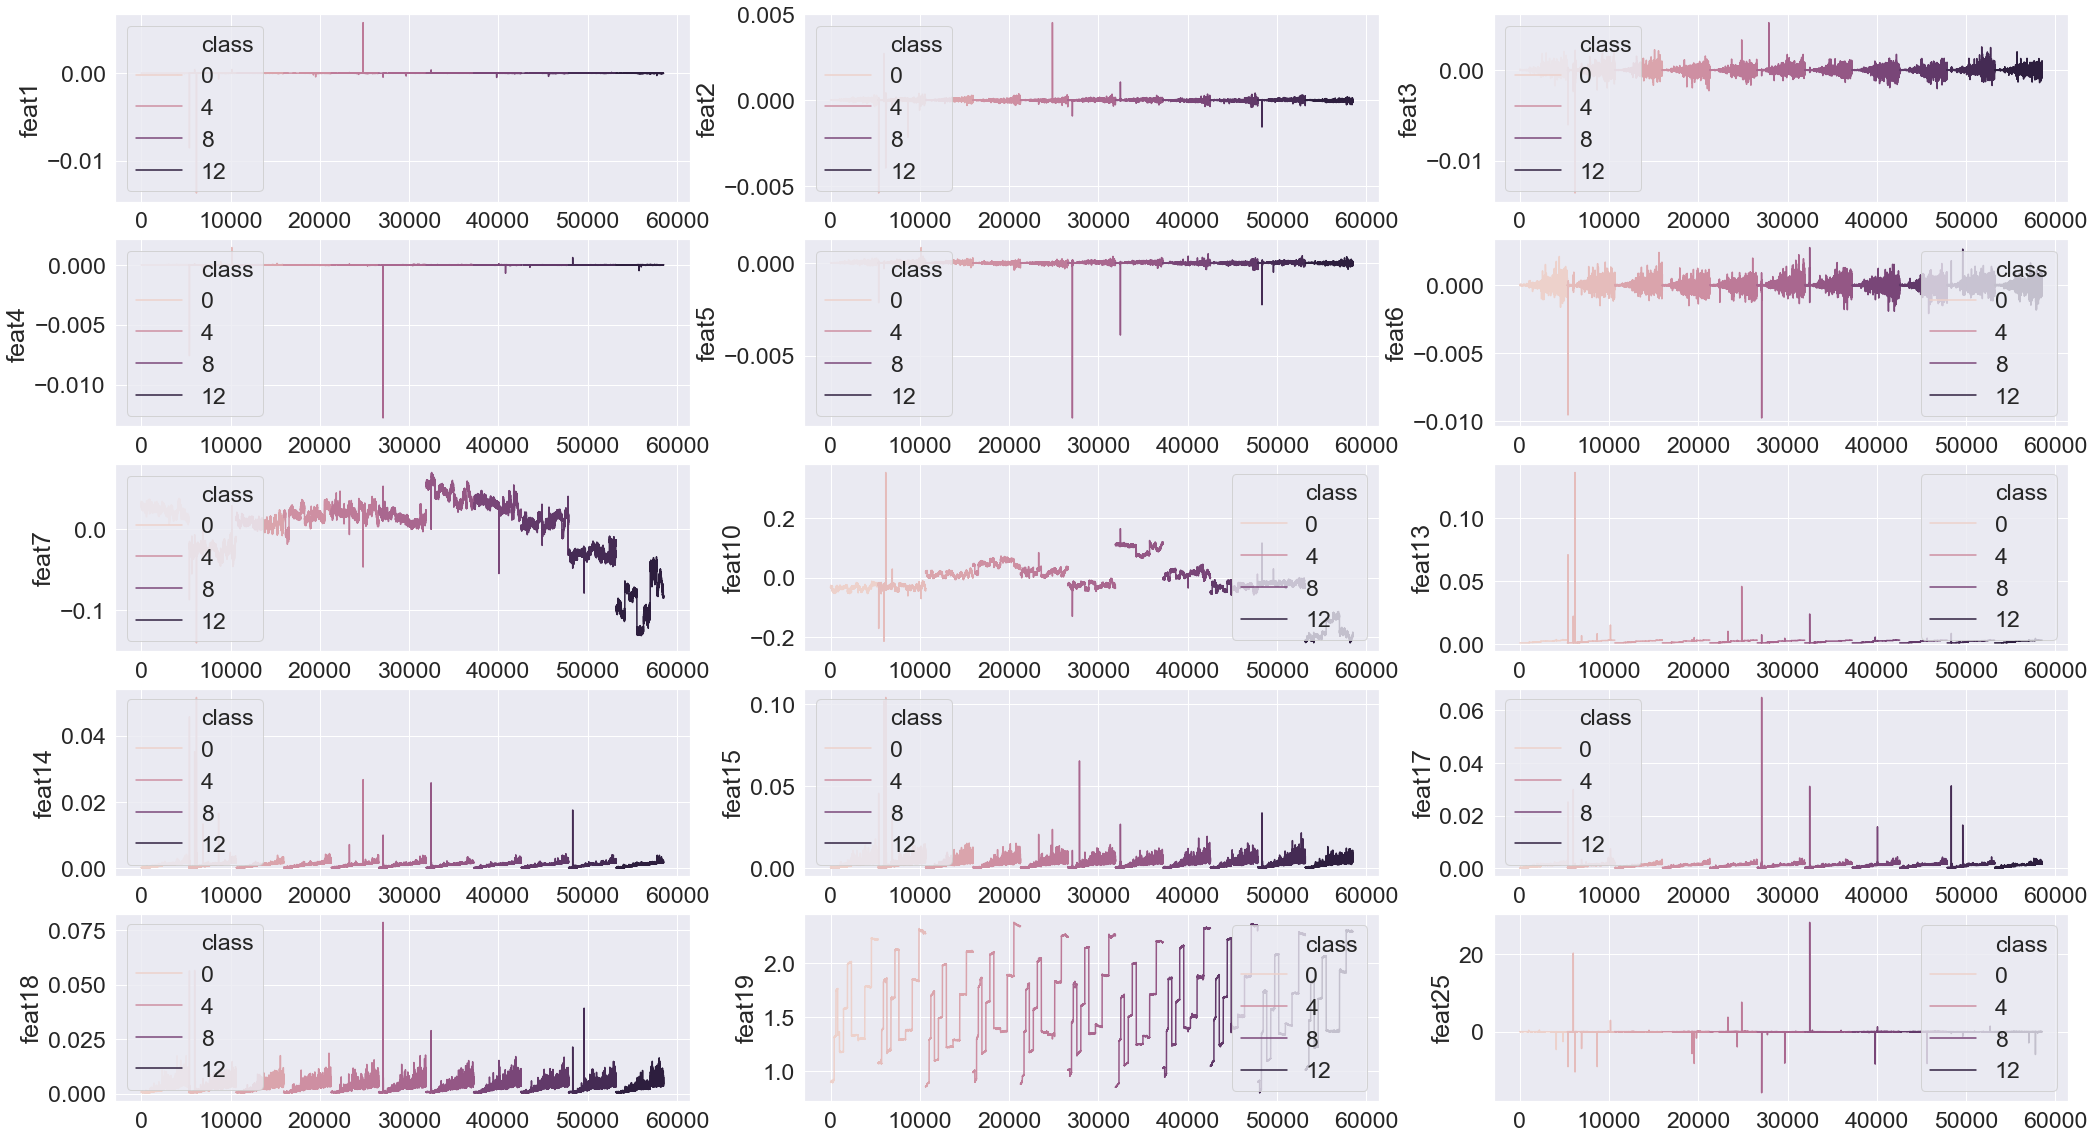

In [69]:
selected_features = ['feat1', 'feat2', 'feat3', 'feat4', 'feat5', 
                     'feat6', 'feat7', 'feat10', 'feat13', 'feat14', 
                     'feat15', 'feat17', 'feat18', 'feat19', 'feat25']
    
fig, ax = plt.subplots(5, 3)
for variable, subplot in zip(selected_features, ax.flatten()):
    sns.lineplot(df.index, df[variable], ax=subplot, hue=df['class'])

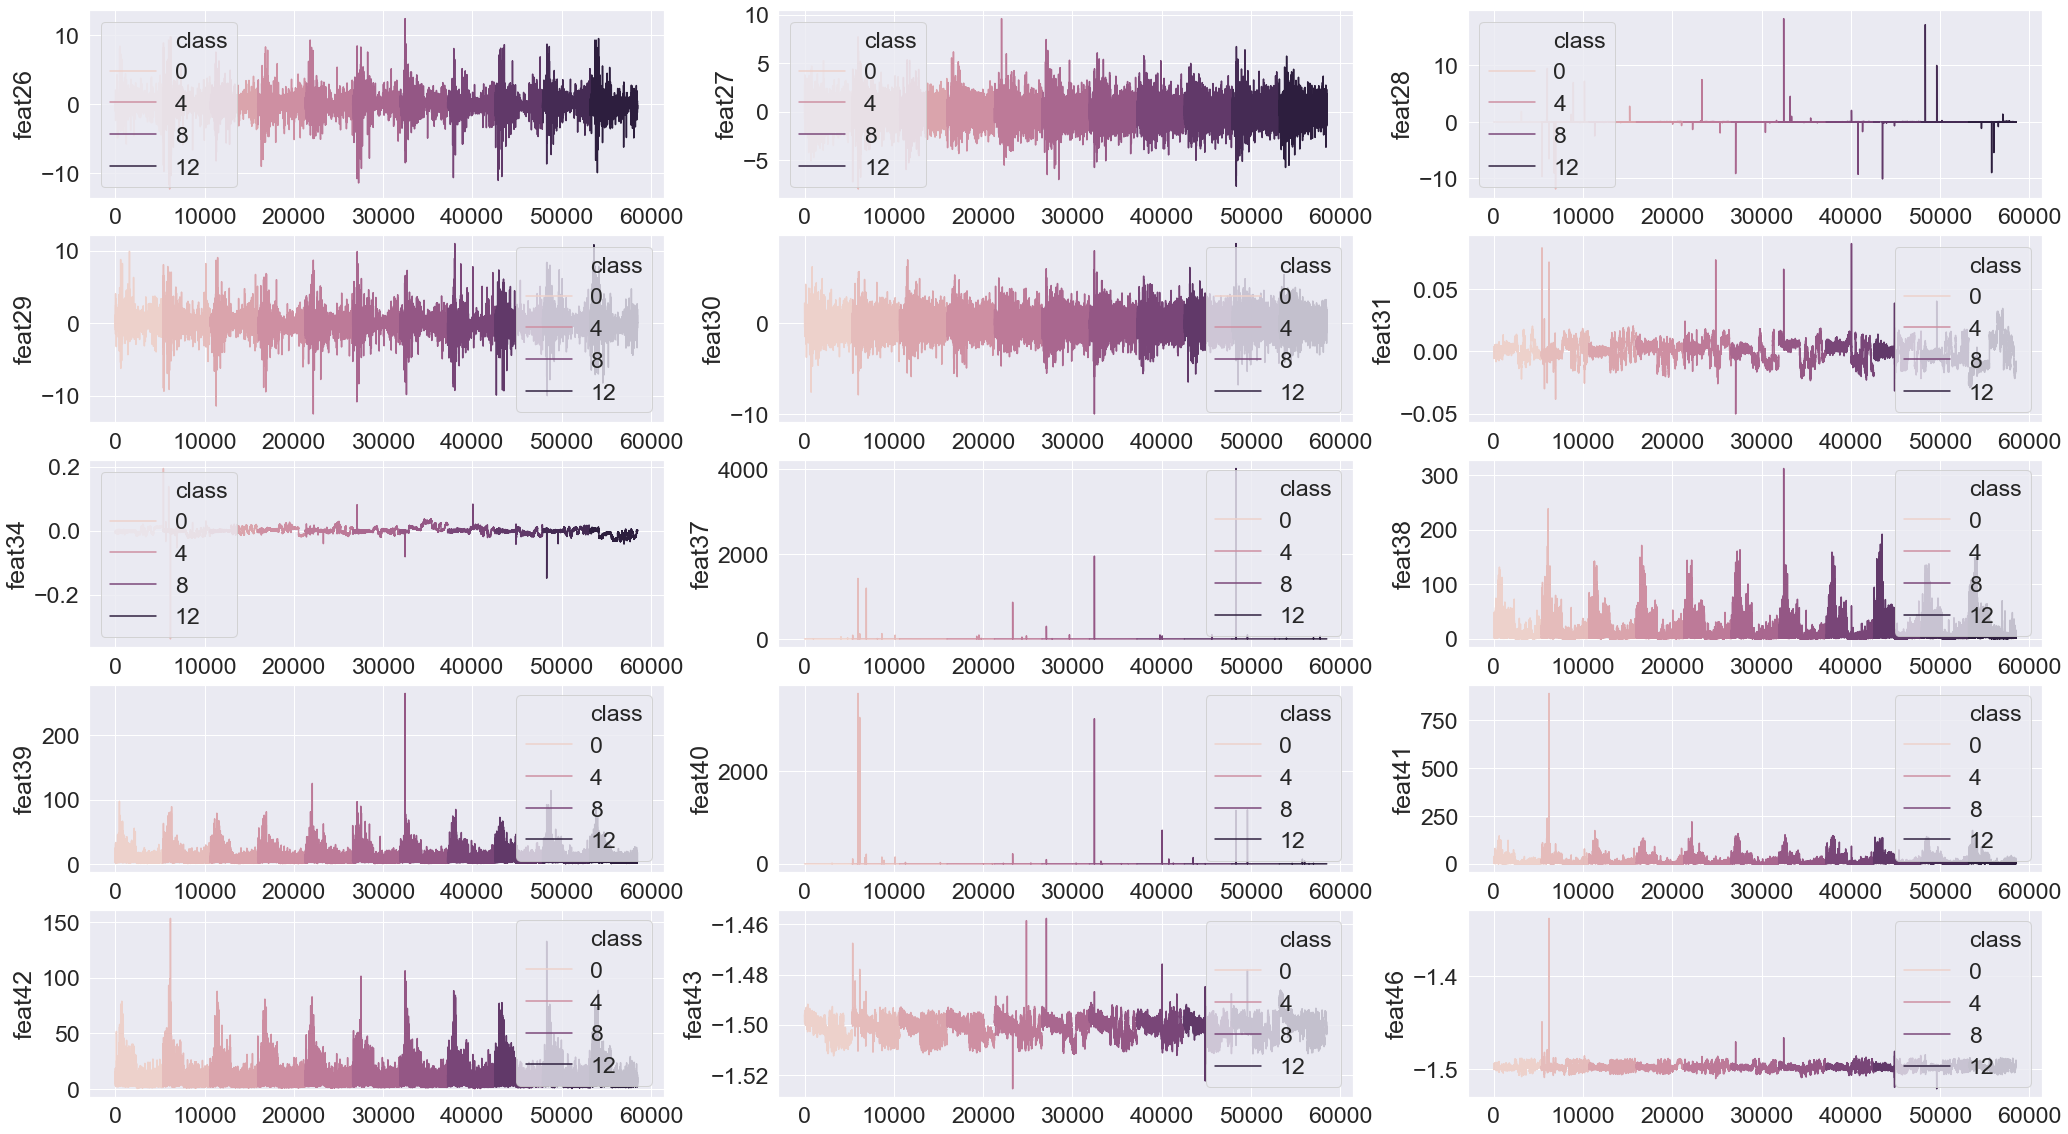

In [70]:
selected_features = ['feat26', 'feat27', 'feat28', 'feat29', 'feat30', 
                     'feat31', 'feat34', 'feat37', 'feat38', 'feat39', 
                     'feat40', 'feat41', 'feat42', 'feat43', 'feat46']
    
fig, ax = plt.subplots(5, 3)
for variable, subplot in zip(selected_features, ax.flatten()):
    sns.lineplot(df.index, df[variable], ax=subplot, hue=df['class'])


## Modelling 

### Models in this notebook: Logistic Regression, Random Forest Classifier, XGBoost Classifier, Multi Layer Perceptron

I decided to use logistic regression as a baseline model. I chose ensemble tree based models as main models. I added a multiclass perceptron as a deep learning model. 


### Splitting The Data Into Test and Train Sets

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

### Scaling Training Data for Logistic Regression Model (Standard Scaler)

In [98]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X_train = pd.DataFrame(scaled_X_train, columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaled_X_test, columns=X_test.columns)

### Baseline Model: Logistic Regression

In [99]:
scaled_X_train_log = scaled_X_train.drop(['feat13', 'feat15', 'feat17' ], axis=1)
scaled_X_test_log = scaled_X_test.drop(['feat13', 'feat15', 'feat17'], axis=1)

In [101]:
scaled_X_test_log.shape

(11702, 27)

In [111]:
log = LogisticRegression(solver='saga', max_iter=5000)
log.fit(scaled_X_train_log, y_train)
y_pred_train = log.predict(scaled_X_train_log)
y_pred_test = log.predict(scaled_X_test_log)

#### Model Evaluation Metrics

In [112]:
model_evaluation(scaled_X_train_log, scaled_X_test_log, y_train, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Train Set Accuracy Score 0.906595
Test Set Accuracy Score 0.904375
-----------------------------------------------------

Confusion Matrix for train & test set: 
 
Train set
 [[4056    0    0    0    0  164    0    0   25    0    0]
 [   0 3745    0    0    0    2    0    0   13  470    0]
 [   0    0 4075  102   98    0    0    0    0    0    0]
 [   0    0  176 3968   69    0   52    6    0    0    0]
 [   0    0  122  160 3359    1    0  611    0    0    0]
 [ 255    6    6    0    3 3479    0    1  512    0    0]
 [   0    0    0   12    0    0 4204    0    0    0    0]
 [   2    1   13   17  351    3    3 3900    0    0    0]
 [  40   18   18    1    0  524    0    2 3699    5    0]
 [   0  506    0    0    1    0    0    0    1 3739    0]
 [   0    0    0    0    0    0    0    0    0    0 4211]] 


Test set

[[1027    0    0    0    0   42    0    0    5    0    0]
 [   1  957    0    0    1    0   

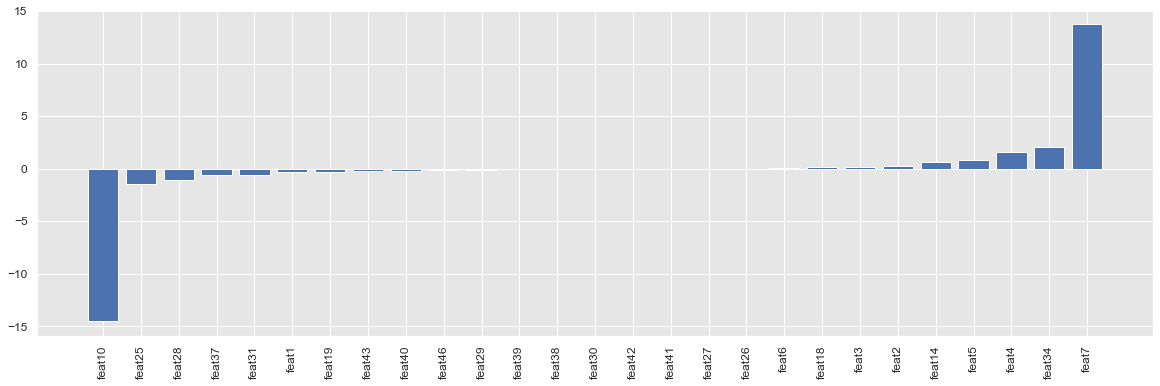

In [113]:
plot_coefficients(log)

### Random Forest Classification Model

In [106]:
rf_clf = RandomForestClassifier(n_jobs=4, class_weight='balanced', random_state=42, n_estimators= 80)
rf_clf.fit(X_train, y_train)
y_pred_train = rf_clf.predict(X_train)
y_pred_test = rf_clf.predict(X_test)

In [109]:
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Train Set Accuracy Score 1.0
Test Set Accuracy Score 0.998376
-----------------------------------------------------

Confusion Matrix for train & test set: 
 
Train set
 [[4245    0    0    0    0    0    0    0    0    0    0]
 [   0 4230    0    0    0    0    0    0    0    0    0]
 [   0    0 4275    0    0    0    0    0    0    0    0]
 [   0    0    0 4271    0    0    0    0    0    0    0]
 [   0    0    0    0 4253    0    0    0    0    0    0]
 [   0    0    0    0    0 4262    0    0    0    0    0]
 [   0    0    0    0    0    0 4216    0    0    0    0]
 [   0    0    0    0    0    0    0 4290    0    0    0]
 [   0    0    0    0    0    0    0    0 4307    0    0]
 [   0    0    0    0    0    0    0    0    0 4247    0]
 [   0    0    0    0    0    0    0    0    0    0 4211]] 


Test set

[[1070    0    0    0    0    4    0    0    0    0    0]
 [   0 1086    0    0    0    0    0   

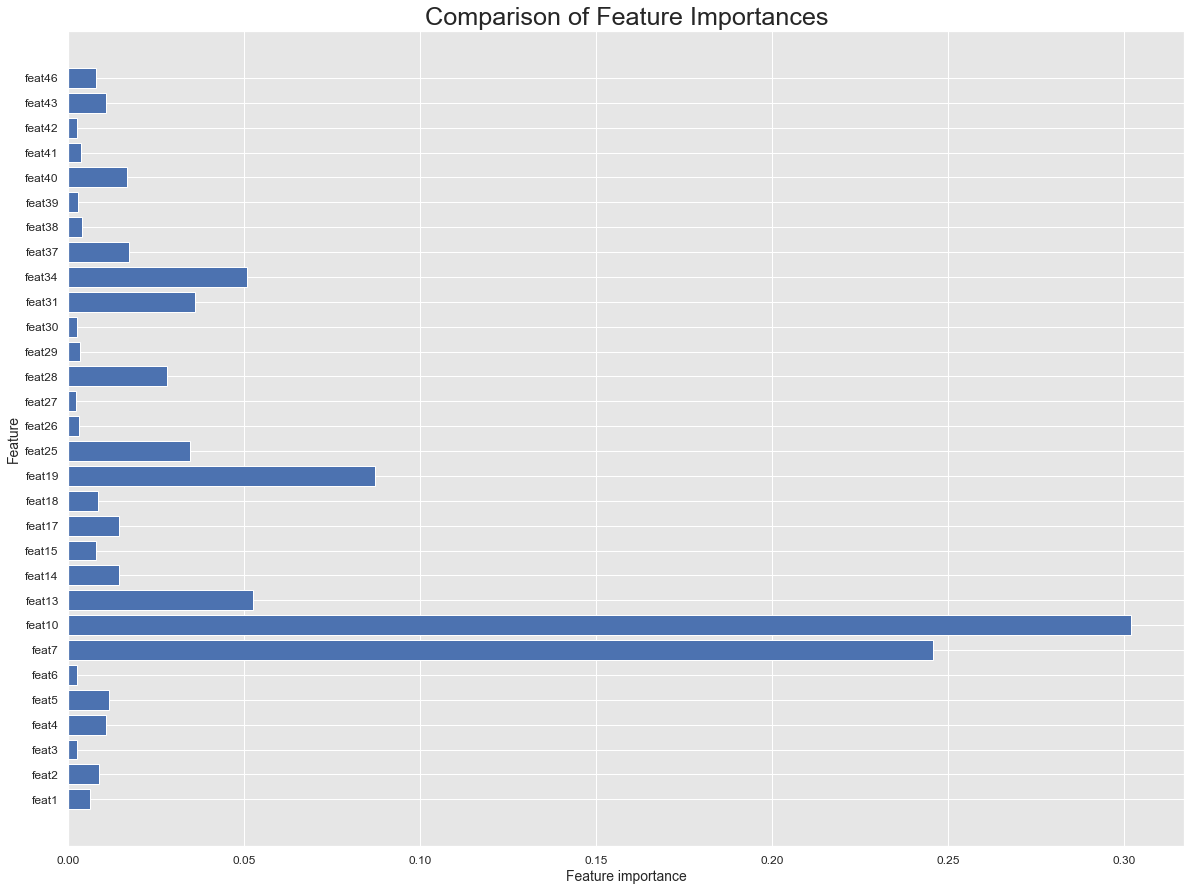

In [110]:
plot_feature_importances(rf_clf)

### Pipeline and Grid Search - Random Forest Classification Model

In [ ]:
pipe = Pipeline([('classifier', RandomForestClassifier(random_state=123))])
grid = [{'classifier__criterion': ['gini', 'entropy'],
         'classifier__n_estimators':[100, 120, 150],
         'classifier__max_depth': [12, 14],
         'classifier__min_samples_split': [4, 6, 8]}]
clf = GridSearchCV(estimator=pipe, param_grid=grid,
                   cv=5, n_jobs=-1)


print("Grid search..")
search_time_start = time.time()

clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

search_time_end = time.time()
print('Time for randomized search: ', search_time_start - search_time_end )

In [ ]:
print("Best Parameter Combination Found During Grid Search:\n ", gsrf_clf.best_params_)

In [ ]:
clf = RandomForestClassifier(n_jobs=4, class_weight='balanced', random_state=42, n_estimators= 80)

### Random Search - XGBoost Classifier 

In [116]:
clf = xgb.XGBClassifier(objective="multi:softmax")
param_grid = {
        'silent': [False],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100]}
RS_clf = RandomizedSearchCV(estimator=clf, param_distributions=param_grid,
                            cv=5, n_jobs=-1)
print("Randomized search..")
search_time_start = time.time()

RS_clf.fit(X_train, y_train)
y_pred_train = RS_clf.predict(X_train)
y_pred_test = RS_clf.predict(X_test)

search_time_end = time.time()
print('Time for randomized search in seconds: ', search_time_end - search_time_start )


Randomized search..
Time for randomized search:  -1900.4228661060333


In [117]:
print("Best Parameter Combination Found During Random Search:\n ", RS_clf.best_params_)

Best Parameter Combination Found During Random Search:
  {'subsample': 0.9, 'silent': False, 'reg_lambda': 0.1, 'n_estimators': 100, 'min_child_weight': 1.0, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.7}


Here are the best parameters of above random search

'subsample': 0.9, 

'reg_lambda': 0.1, 

'n_estimators': 100, 

'min_child_weight': 1.0, 

'max_depth': 10, 

'learning_rate': 0.1, 

'gamma': 0.5, 

'colsample_bytree': 0.7

### Final XGBoost Model 

In [118]:
clf = xgb.XGBClassifier(objective='multi:softmax', nthread=4, scale_pos_weight=3,
                        colsample_bytree= 0.7, gamma= 0.5, learning_rate= 0.1, 
                        max_depth= 10,min_child_weight= 1.0, reg_lambda= 1.0, 
                        silent= False, subsample= 0.9, seed=42, n_estimators=100)
search_time_start = time.time()
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

search_time_end = time.time()
print('Time for the final XG Boost model in seconds: ', search_time_end - search_time_start )


Time for the final XG Boost model in seconds:  77.83048820495605


#### Model Evaluation Metrics

In [119]:
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Train Set Accuracy Score 1.0
Test Set Accuracy Score 0.998547
-----------------------------------------------------

Confusion Matrix for train & test set: 
 
Train set
 [[4245    0    0    0    0    0    0    0    0    0    0]
 [   0 4230    0    0    0    0    0    0    0    0    0]
 [   0    0 4275    0    0    0    0    0    0    0    0]
 [   0    0    0 4271    0    0    0    0    0    0    0]
 [   0    0    0    0 4253    0    0    0    0    0    0]
 [   0    0    0    0    0 4262    0    0    0    0    0]
 [   0    0    0    0    0    0 4216    0    0    0    0]
 [   0    0    0    0    0    0    0 4290    0    0    0]
 [   0    0    0    0    0    0    0    0 4307    0    0]
 [   0    0    0    0    0    0    0    0    0 4247    0]
 [   0    0    0    0    0    0    0    0    0    0 4211]] 


Test set

[[1070    0    0    0    0    4    0    0    0    0    0]
 [   0 1087    0    0    0    0    0   

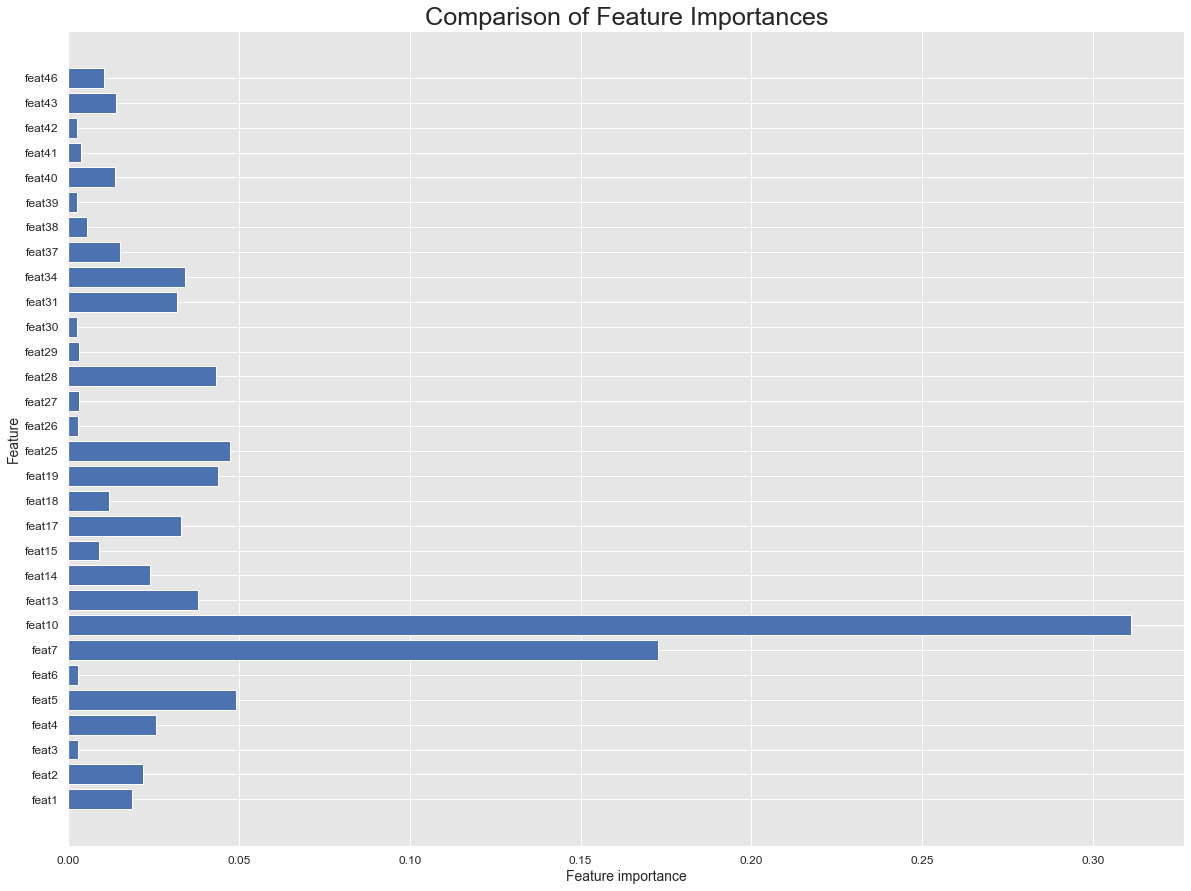

In [120]:
plot_feature_importances(clf)

### Multi Layer Perceptron Model

In [124]:
search_time_start = time.time()

print('Multi Layer Perceptron')

mlp = MLPClassifier(hidden_layer_sizes=(128,128,128,128,128,128), activation='relu', 
                    solver='adam', max_iter=500, verbose=True)
mlp.fit(X_train,y_train)
Y_train_mlp_pred_df = mlp.predict(X_train)
Y_valid_mlp_pred_df = mlp.predict(X_test)

search_time_end = time.time()
print('Time for the final MLP model in seconds: ', search_time_end - search_time_start )


Multi Layer Perceptron
Iteration 1, loss = 2.37998875
Iteration 2, loss = 1.57474917
Iteration 3, loss = 0.99974834
Iteration 4, loss = 0.89879132
Iteration 5, loss = 0.82755393
Iteration 6, loss = 0.75518086
Iteration 7, loss = 0.74886603
Iteration 8, loss = 0.71529770
Iteration 9, loss = 0.69437974
Iteration 10, loss = 0.70754428
Iteration 11, loss = 0.65193647
Iteration 12, loss = 0.65900269
Iteration 13, loss = 0.64150487
Iteration 14, loss = 0.66124980
Iteration 15, loss = 0.63801795
Iteration 16, loss = 0.63431979
Iteration 17, loss = 0.59694176
Iteration 18, loss = 0.60735879
Iteration 19, loss = 0.59885550
Iteration 20, loss = 0.55108493
Iteration 21, loss = 0.54588318
Iteration 22, loss = 0.52352459
Iteration 23, loss = 0.41622125
Iteration 24, loss = 0.33772503
Iteration 25, loss = 0.30092181
Iteration 26, loss = 0.31759106
Iteration 27, loss = 0.24304605
Iteration 28, loss = 0.22103502
Iteration 29, loss = 0.23360473
Iteration 30, loss = 0.19784947
Iteration 31, loss = 0.225

In [127]:
cm_mlp_train = confusion_matrix(y_train, Y_train_mlp_pred_df)
print(cm_mlp_train)
mlp_train_accuracy = cm_mlp_train.trace()/cm_mlp_train.sum()

print('MLP accuracy on a train set is: ', round(mlp_train_accuracy, 6))
print(60*'-')

cm_mlp = confusion_matrix(y_test, Y_valid_mlp_pred_df)
print(cm_mlp)
mlp_test_accuracy = cm_mlp.trace()/cm_mlp.sum()

print('MLP accuracy on a test set is: ', round(mlp_test_accuracy, 6))


[[4070    0    0    0    0  147    0    0   28    0    0]
 [   0 3452    1    1    0    0    0    0    4  772    0]
 [   0    9 4221   11   33    0    0    0    1    0    0]
 [   0    1   19 4238    7    0    2    0    1    3    0]
 [   0    2  126   17 3998    1    0  107    1    1    0]
 [  63    1   19    0    0 3846    0    2  331    0    0]
 [   0    0    0    0    0    0 4216    0    0    0    0]
 [   0    1    6    4  181   30    0 4067    0    1    0]
 [   3   12    8    0    1   64    0    2 4216    1    0]
 [   0  106    0    0    1    0    0    0    0 4140    0]
 [   0    2    0    0    1    0    0    0    0    0 4208]]
MLP accuracy on a train set is:  0.954387
------------------------------------------------------------
[[1019    0    0    0    0   47    0    0    8    0    0]
 [   0  883    0    0    2    0    0    0    0  204    0]
 [   0    3 1028    0   13    0    0    0    0    0    0]
 [   0    0    6 1037    2    0    2    0    1    0    0]
 [   0    0   36    8  993

In [ ]:
def baseline_model(input_dim,output_dim):
    model = Sequential()
    model.add(Dense(input_dim, input_dim=input_dim, activation='relu'))
    model.add(Dense(input_dim*2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(input_dim*2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(input_dim*2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(input_dim*2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(input_dim//2, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    return model

In [3]:
import sklearn
print(sklearn.__version__)

0.23.2


In [9]:
import xgboost
print(xgboost.__version__)

0.90
